In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [18]:
import json
import re
import pickle
from dotenv import find_dotenv, load_dotenv

from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from src import elastic_search_engine, rag, llm

load_dotenv(find_dotenv('../.env'))

True

In [6]:
with open('../data/initial_data_w_id.json', 'r') as f_in:
    documents = json.load(f_in)

In [7]:
doc_idx = {d['id']: d for d in documents}

# Example of a possible RAG

In [8]:
elastic_semantic_searcher = elastic_search_engine.ElasticSemanticSearcher(index_name='vague-actual-mpnet')
prompt_template = """
    Your are a translator from vague boss language into an everyday language. Translate
    the VAGUE statement or question based on the CONTEXT. Provide a clear and concise translation. Provide only the translation and no other information.
    VAGUE: {vague}
    
    CONTEXT: {context}
    """.strip()
    
chatgpt_4o_mini = rag.ChatGPTRAG(elastic_searcher=elastic_semantic_searcher,
                 prompt_template=prompt_template, 
                 llm_model='gpt-4o-mini',
                 sentence_transformer_name='all-mpnet-base-v2')

/home/taras/.local/share/virtualenvs/llm-zoomcamp-sfbU5DAF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
chatgpt_4o_mini.rag_results('We need to become Speedy Gonzales and kick it into hyperdrive or we are going to be stuck in traffic.')

'We need to speed up our work to avoid delays.'

## Evaluation for different RAGs

In [10]:
ground_truth = pd.read_csv('../data/ground_truth_data.csv')

I will randomly take 800 documents for RAG evaluation to save time and money.

In [11]:
ground_truth = ground_truth.sample(800)

In [12]:
ground_truth = ground_truth.to_dict(orient='records')

In [32]:
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f, model):
    results = []
    with tqdm(total=len(seq)) as progress:
        futures = []
        for el in seq:
            future = pool.submit(f, el, model)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)
        for future in futures:
            result = future.result()
            results.append(result)
    return results

In [14]:
def process_record(rec, model):
    answer_llm = model.rag_results(rec['vague'])
    
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['actual']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'vague': rec['vague'],
    }

In [15]:
process_record(ground_truth[5], chatgpt_4o_mini)

{'answer_llm': 'We need to organize our strategies to align with the overall company goals.',
 'answer_orig': 'We need to organize our resources as we work to improve our IT infrastructure.',
 'document': '71431fe22ddd3f00f79bea0c094d92e5',
 'vague': 'We should get our ducks in order as we navigate towards a stronger infrastructure.'}

In [ ]:
result_prompt_standard = map_progress(pool, ground_truth, process_record, chatgpt_4o_mini)

In [ ]:
pd.DataFrame(result_prompt_standard).to_csv(r'../data/standard_prompt_rag_evaluation.csv', index=False)

## Adding one more candidate. Ambiguity resolver RAG.

In [16]:
ambiguity_resolver_prompt = """You are an Ambiguity Resolver for tech management communication. Your task is to:

1. Interpret the VAGUE STATEMENT from an IT manager
2. Consider the given CONTEXT
3. Rewrite the statement in clear, specific, and actionable terms

Provide only the rewritten statement without additional commentary.

VAGUE STATEMENT: {vague}

CONTEXT: {context}

CLEAR STATEMENT:""".strip()

In [17]:
# defining new RAG with a prompt above
ambiguity_resolver_rag= rag.ChatGPTRAG(elastic_searcher=elastic_semantic_searcher,
                 prompt_template=ambiguity_resolver_prompt, 
                 llm_model='gpt-4o-mini',
                 sentence_transformer_name='all-mpnet-base-v2')

/home/taras/.local/share/virtualenvs/llm-zoomcamp-sfbU5DAF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Exaple of usage
ambiguity_resolver_rag.rag_results('We need to become Speedy Gonzales and kick it into hyperdrive or we are going to be stuck in traffic.')

'We need to accelerate our development process to ensure we meet project deadlines.'

In [20]:
result_ambiguity_resolver = map_progress(pool, ground_truth, process_record, ambiguity_resolver_rag)

  0%|          | 0/800 [00:00<?, ?it/s]

In [21]:
pd.DataFrame(result_ambiguity_resolver).to_csv('../data/ambiguity_resolver_rag_evaluation.csv', index=False)

### Comparing

In [8]:
def compute_similarity(record, sentence_transformer_model):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = sentence_transformer_model.encode(answer_llm)
    v_orig = sentence_transformer_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)


In [4]:
standard_rag_evaluation = pd.read_csv(r'../data/standard_prompt_rag_evaluation.csv')
ambiguity_resolver_rag_evalution = pd.read_csv('../data/ambiguity_resolver_rag_evaluation.csv')
sentence_model_transformer = SentenceTransformer('all-mpnet-base-v2')

/home/taras/.local/share/virtualenvs/llm-zoomcamp-sfbU5DAF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
standard_rag_results = [compute_similarity(rec, sentence_transformer_model=sentence_model_transformer)
                        for rec in standard_rag_evaluation.to_dict(orient='records')]

In [10]:
ambiguity_resolver_rag_results = [compute_similarity(rec, sentence_transformer_model=sentence_model_transformer)
                        for rec in ambiguity_resolver_rag_evalution.to_dict(orient='records')]

In [13]:
pd.DataFrame({'sim': standard_rag_results}).to_csv('../data/standard_rag_results.csv', index=False)
pd.DataFrame({'sim': ambiguity_resolver_rag_results}).to_csv('../data/ambiguity_resolver_rag_results.csv', index=False)

/tmp/ipykernel_25820/30980072.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(standard_rag_results, label='standard')
/tmp/ipykernel_25820/30980072.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ambiguity_resolver_rag_results, label='ambiguity_resolver')


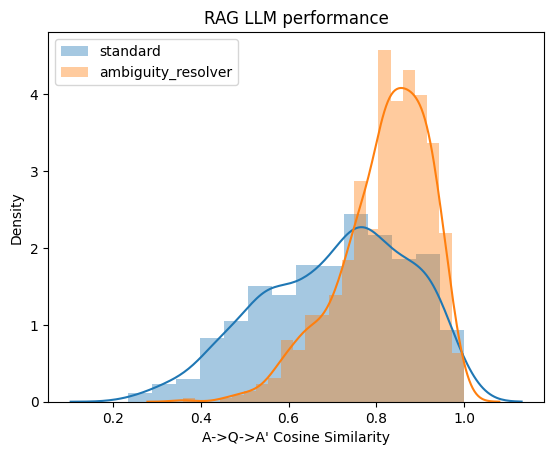

In [17]:

sns.distplot(standard_rag_results, label='standard')
sns.distplot(ambiguity_resolver_rag_results, label='ambiguity_resolver')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()


## LLM-as-a-judge

Taking 100 random samples for LLM-as-a-judge evaluation

In [9]:
standard_rag_evaluation_sample = standard_rag_evaluation.drop(columns=['document']).sample(100).to_dict(orient='records')
ambiguity_resolver_rag_evalution_sample = ambiguity_resolver_rag_evalution.drop(columns=['document']).sample(100).to_dict(orient='records')

In [30]:
judge_prompt_template = """ 
LLM-as-a-Judge Prompt for RAG Evaluation
You are an expert judge evaluating the performance of a Retrieval-Augmented Generation (RAG) system. This system is designed to translate vague statements from IT bosses into their actual meanings. Your task is to assess the quality and accuracy of the RAG system's translations.
For each example, you will be provided with:

The original vague statement or question from the IT boss
The actual meaning or intended question (ground truth)
The RAG system's translation

Input Data
Please evaluate the following translation:
Vague IT boss question: {vague}
Actual Meaning: {answer_orig}
RAG Translation: {answer_llm}

Evaluation Criteria
Your job is to:

Analyze the RAG system's translation compared to the actual meaning.
Evaluate the translation on the following criteria:
a. Accuracy: How well does the translation capture the intended meaning?
b. Clarity: Is the translation clear and easy to understand?
c. Completeness: Does the translation cover all important aspects of the actual meaning?
d. Relevance: Does the translation focus on the most important parts of the vague statement?
Provide a score for each criterion on a scale of 1-5, where:
1 = Poor
2 = Fair
3 = Good
4 = Very Good
5 = Excellent
Give an overall score (1-5) for the translation.
Provide a brief explanation (2-3 sentences) for your scoring, highlighting strengths and areas for improvement.
If the translation is incorrect or misleading, explain what went wrong and suggest how it could be improved.

Output Format
Please structure your evaluation like this:
Criteria Scores:

Accuracy: [Score]
Clarity: [Score]
Completeness: [Score]
Relevance: [Score]

Overall Score: [Score]
Explanation: [Your brief explanation]
Improvement Suggestions (if necessary): [Your suggestions]
Please provide your evaluation for the given example.
""".strip()

#### Standard Prompt

In [35]:
standard_rag_judged_results = []
for rec in tqdm(standard_rag_evaluation_sample):
    rec['vague'] = rec.pop('question')
    judge_prompt = judge_prompt_template.format(**rec)
    standard_rag_judged_results.append(llm.llm(prompt=judge_prompt, gpt_model='gpt-4o-mini'))

  0%|          | 0/100 [00:00<?, ?it/s]

#### Ambiguity Resolver

In [37]:
ambiguity_resolver_judged_results = []
for rec in tqdm(ambiguity_resolver_rag_evalution_sample):
    judge_prompt = judge_prompt_template.format(**rec)
    ambiguity_resolver_judged_results.append(llm.llm(prompt=judge_prompt, gpt_model='gpt-4o-mini'))

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
with open('../data/ambiguity_resolver_judged_results.pkl', 'wb') as f_in:
    pickle.dump(ambiguity_resolver_judged_results, f_in)
with open('../data/standard_rag_judged_results.pkl', 'wb') as f_in:
    pickle.dump(standard_rag_judged_results, f_in)    

In [28]:
def parse_evaluation_text(text: str) -> dict:
    """

    Args:
        text str: answer got from Judge-LLM (gpt-5o-mini)

    Returns:
        dict: of the following format  {'Criteri Scores': {'Clarity':..., 'Relevance':..., 'Accuracy':..., 'Completeness':...}, 'Overall Score': ...,
        'Explanation':..., 'Imporvement Suggestions': ...}
    """
    # Initialize the dictionary
    result = {"Criteria Scores": {}}
    
    # Use regex to extract key-value pairs
    patterns = {
        "Criteria Scores": r'(\w+):\s*(\d+)',
        "Overall Score": r'Overall Score:\s*([\d.]+)',
        "Explanation": r'Explanation:\s*(.*?)(?=\n\n|\Z)',
        "Improvement Suggestions": r'Improvement Suggestions:\s*(.*?)(?=\n\n|\Z)'
    }
    
    # Extract Criteria Scores
    criteria_scores = re.findall(patterns["Criteria Scores"], text)
    for criterion, score in criteria_scores:
        result["Criteria Scores"][criterion] = int(score)
    
    # Extract other fields
    for key, pattern in patterns.items():
        if key != "Criteria Scores":
            match = re.search(pattern, text, re.DOTALL)
            if match:
                value = match.group(1).strip()
                result[key] = float(value) if key == "Overall Score" else value
    
    return result

In [44]:
# parsing results from hot from Judge-LLM
ambiguity_resolver_judged_results_parsed = [ parse_evaluation_text(res) for res in ambiguity_resolver_judged_results]
standard_rag_judged_results_parsed = [ parse_evaluation_text(res) for res in standard_rag_judged_results]

##### Looking at different metrics fro Judge-LLM

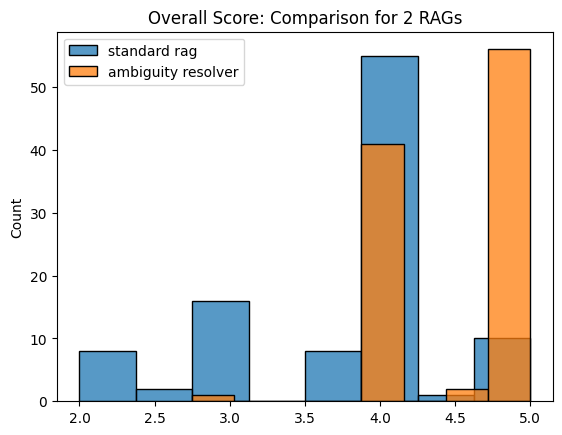

In [50]:
sns.histplot([res['Overall Score'] for res in standard_rag_judged_results_parsed], label = 'standard rag')
sns.histplot([res['Overall Score'] for res in ambiguity_resolver_judged_results_parsed], label = 'ambiguity resolver')
plt.title('Overall Score: Comparison for 2 RAGs')
plt.legend()

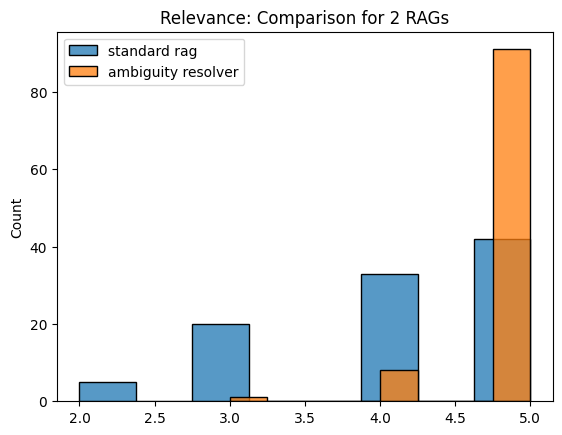

In [52]:
sns.histplot([res['Criteria Scores']['Relevance'] for res in standard_rag_judged_results_parsed], label = 'standard rag')
sns.histplot([res['Criteria Scores']['Relevance'] for res in ambiguity_resolver_judged_results_parsed], label = 'ambiguity resolver')
plt.title('Relevance: Comparison for 2 RAGs')
plt.legend()

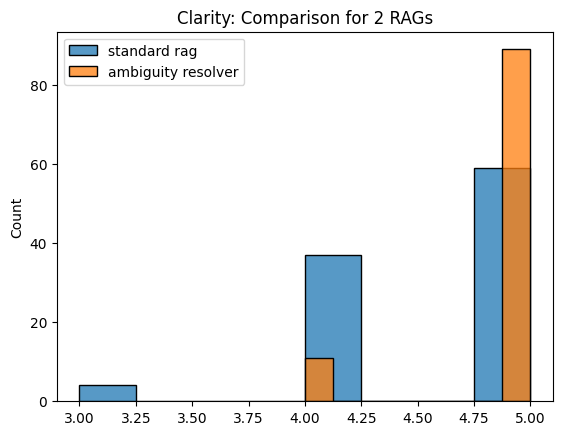

In [53]:
sns.histplot([res['Criteria Scores']['Clarity'] for res in standard_rag_judged_results_parsed], label = 'standard rag')
sns.histplot([res['Criteria Scores']['Clarity'] for res in ambiguity_resolver_judged_results_parsed], label = 'ambiguity resolver')
plt.title('Clarity: Comparison for 2 RAGs')
plt.legend()

In [55]:
standard_rag_judged_results_parsed[:5]

[{'Criteria Scores': {'Accuracy': 4,
   'Clarity': 5,
   'Completeness': 3,
   'Relevance': 4,
   'Score': 4},
  'Overall Score': 4.0,
  'Explanation': "The RAG system's translation accurately conveys the essence of the original vague statement by indicating that there is a need to identify important parts of the data. It is clear and easy to understand. However, it could be improved in completeness, as it does not explicitly mention analyzing the data to extract useful insights, which is a key aspect of the original meaning."},
 {'Criteria Scores': {'Accuracy': 2,
   'Clarity': 4,
   'Completeness': 3,
   'Relevance': 3,
   'Score': 3},
  'Overall Score': 3.0,
  'Explanation': 'The RAG translation attempts to convey a sense of managing expectations but misses the core objective of seeking strategies specifically for improving user engagement. While it is somewhat clear and easy to understand, it lacks accuracy in capturing the intended meaning of the original statement. The translatio

## Summary
In what follows I wil use ambiguity_resolver rag.